In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol
from sympy import solve, Poly, Eq, Function, exp
import math
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks
from scipy.constants import lambda2nu, nu2lambda, c
import os
import imp
import matplotlib.pyplot as plt
import sys

#windows path
#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\') 
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')

#linux path
sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/moises/Downloads/'))

In [9]:
fdtd = lumapi.FDTD(filename= 'BEND.fsp')

In [3]:
material_core = 'Si (Silicon) - Palik'
material_subs = 'SiO2 (Glass) - Palik'
width = 0.5e-6
height = 0.22e-6
radius = 4e-6

In [6]:
fdtd.switchtolayout()
fdtd.selectall()
fdtd.delete()

fdtd.addobject('90_bend_wg')
fdtd.set({
'x':0,
'y':0,
'z':0,
'base angle':90,
'base height':height,
'base width':width,
'radius':radius,
'material':material_core
})

fdtd.addrect()
fdtd.set({
'name':'rect_after',
'x':radius,
'x span':width,
'y max':0,
'y min':-1e-6,
'z':0,
'z span':0.22e-6,
'material':material_core
})

fdtd.addrect()
fdtd.set({
'name':'rect_before',
'x min':-1e-6,
'x max':0,
'y max':radius + width/2,
'y min':radius - width/2,
'z':0,
'z span':0.22e-6,
'material':material_core
})


In [10]:
fdtd.switchtolayout()
fdtd.select('FDTD')
fdtd.delete()
fdtd.select('monitor')
fdtd.delete()

mesh = 5

fdtd.addfdtd()
fdtd.set({'x min':-0.5e-6,
'x max':radius + 2.25e-6,
'y min':-0.5e-6,
'y max':radius + width/2 + 2e-6,
'z':0,
'z span':4e-6,
'simulation time':1250e-15,
'mesh accuracy':mesh,
'background material':material_subs})

fdtd.addport()
fdtd.set({
'x':0,
'y':radius,
'y span':4e-6,
'z':0,
'z span':4e-6
})


fdtd.addport()
fdtd.set({
'injection axis':'y-axis',
'Direction':'Forward',
'y':0,
'x':radius,
'x span':4e-6,
'z':0,
'z span':4e-6
})

fdtd.select('FDTD::ports')
fdtd.set('monitor frequency points', 100)

fdtd.addprofile()
fdtd.set({'x min':-0.5e-6,
'x max':radius + 2e-6,
'y min':-0.5e-6,
'y max':radius + width/2 + 2e-6,
'z':0})

fdtd.select('monitor')
fdtd.set('override global monitor settings', 1)
fdtd.set('frequency points', 100)
#fdtd.run()

In [11]:
eField = np.squeeze(fdtd.getelectric("monitor"))

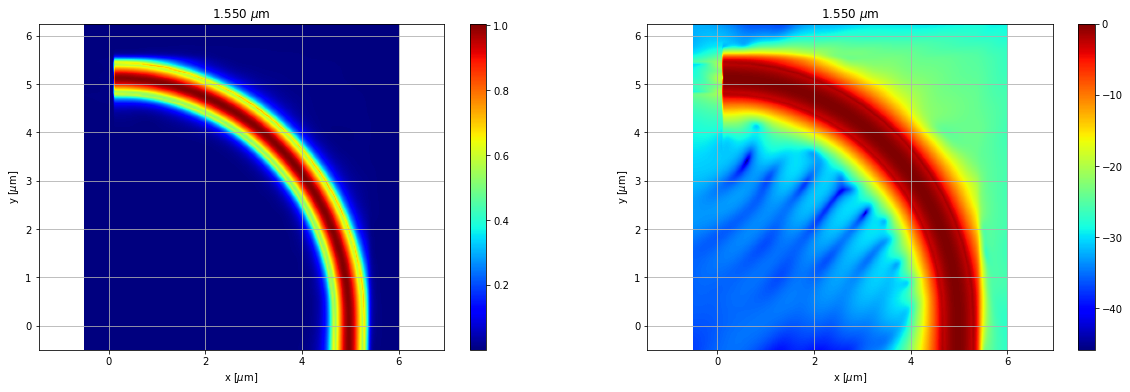

In [12]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

indxLambda = 43
x_efielf = fdtd.getdata("monitor", "x")
y_efielf = fdtd.getdata("monitor", "y")
lmbd = nu2lambda(fdtd.getdata("monitor", "f"))
xmin = 1e6*np.min(x_efielf);
xmax = 1e6*np.max(x_efielf);
ymin = 1e6*np.min(y_efielf);
ymax = 1e6*np.max(y_efielf);

fig1, axs1 = plt.subplots(1,2,figsize=(20,6))
im1 = axs1[0].imshow(np.rot90(np.sqrt(eField[:,:,indxLambda])), cmap = 'jet', extent=[xmin, xmax, ymin, ymax])
fig1.colorbar(im1, ax=axs1[0])
axs1[0].set_xlabel(r'x [$\mu$m]')
axs1[0].set_ylabel(r'y [$\mu$m]')
axs1[0].set_title(r'%4.3f $\mu$m'%(1e6*lmbd[indxLambda]))
axs1[0].grid(True)
axs1[0].axis('equal')

im2 = axs1[1].imshow(10*np.log10(np.rot90(np.sqrt(eField[:,:,indxLambda]))), cmap = 'jet', extent=[xmin, xmax, ymin, ymax])
fig1.colorbar(im2, ax=axs1[1])
axs1[1].set_xlabel(r'x [$\mu$m]')
axs1[1].set_ylabel(r'y [$\mu$m]')
axs1[1].set_title(r'%4.3f $\mu$m'%(1e6*lmbd[indxLambda]))
axs1[1].grid(True)
axs1[1].axis('equal')

fig1.tight_layout
plt.rcParams.update({'font.size': 16})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


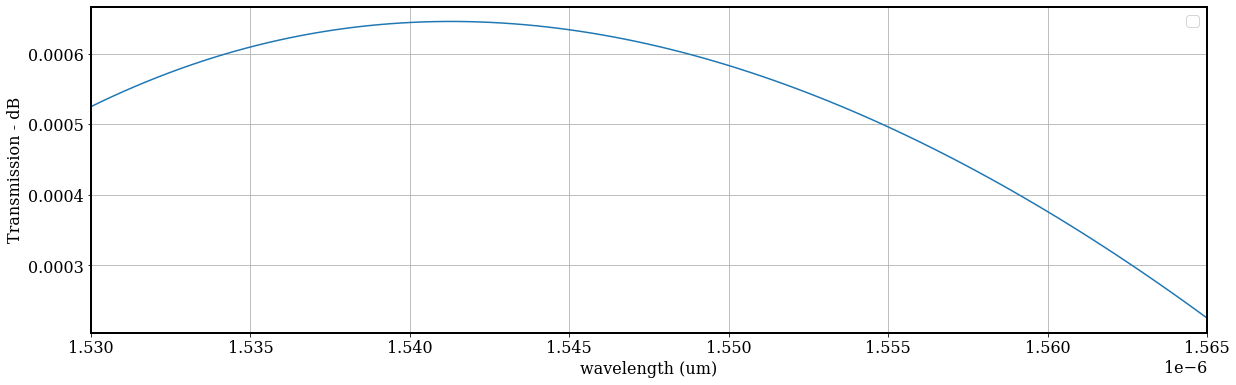

In [39]:
R1 = fdtd.getresult('FDTD::ports::port 1', 'T')
R2 = fdtd.getresult('FDTD::ports::port 2', 'T')


T1 = 10*np.log10(R1['T'])
T2 = 10*np.log10(R1['T'])

wavelength = R2['lambda']

figure = plt.figure(figsize = (20,6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)

plt.plot(wavelength,T2)
plt.xlabel('wavelength (um)')
plt.ylabel('Transmission - dB')
plt.xlim([1.53e-6,1.565e-6])
plt.grid(True)
plt.legend(loc = 'upper right')
